## Repo Analysis

In [3]:
from utils.git_utils import clone_repo
from pathlib import Path
from analyzers.code_analyzer import RepoAnalyzer, NodeKind, is_kind, EdgeType
url = 'https://github.com/adiprerepa/cs598APE-hw1'
branch = 'pesquared-starting'

analyzer = RepoAnalyzer(url, branch)
PROJECT_DIR = analyzer.repo_path

✅ Uber file generated at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/__uber.cpp
Found 8142 nodes
Found 8452 edges
✅ Library subgraph saved to /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/lib_subgraph.gpickle
Found Makefile: /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/Makefile


⚠️ Graph is not a DAG. Using SCC condensation for level estimation.
⚠️ Found cycles: [['Box::getIntersection(Ray)', 'Disk::getIntersection(Ray)'], ['Box::getIntersection(Ray)', 'Disk::getIntersection(Ray)', 'Triangle::getIntersection(Ray)'], ['Box::getIntersection(Ray)', 'Triangle::getIntersection(Ray)', 'Disk::getIntersection(Ray)'], ['Box::getIntersection(Ray)', 'Triangle::getIntersection(Ray)'], ['Disk::getIntersection(Ray)', 'Triangle::getIntersection(Ray)'], ['Plane::getColor(unsigned char *, double *, double *, double *, Autonoma *, Ray, unsigned int)', 'Sphere::getColor(unsigned char *, double *, double *, double *, Autonoma *, Ray, unsigned int)'], ['Camera::Camera', 'BVHNode::right', 'BVHNode::BVHNode', 'BVHNode::shape', 'Shape::Shape', 'Autonoma::Autonoma', 'Autonoma::camera'], ['Camera::Camera', 'BVHNode::right', 'BVHNode::BVHNode', 'BVHNode::shape', 'Shape::Shape', 'Autonoma::Autonoma'], ['Camera::Camera', 'BVHNode::right', 'BVHNode::BVHNode', 'Shape::Shape', 'Autonoma::Aut

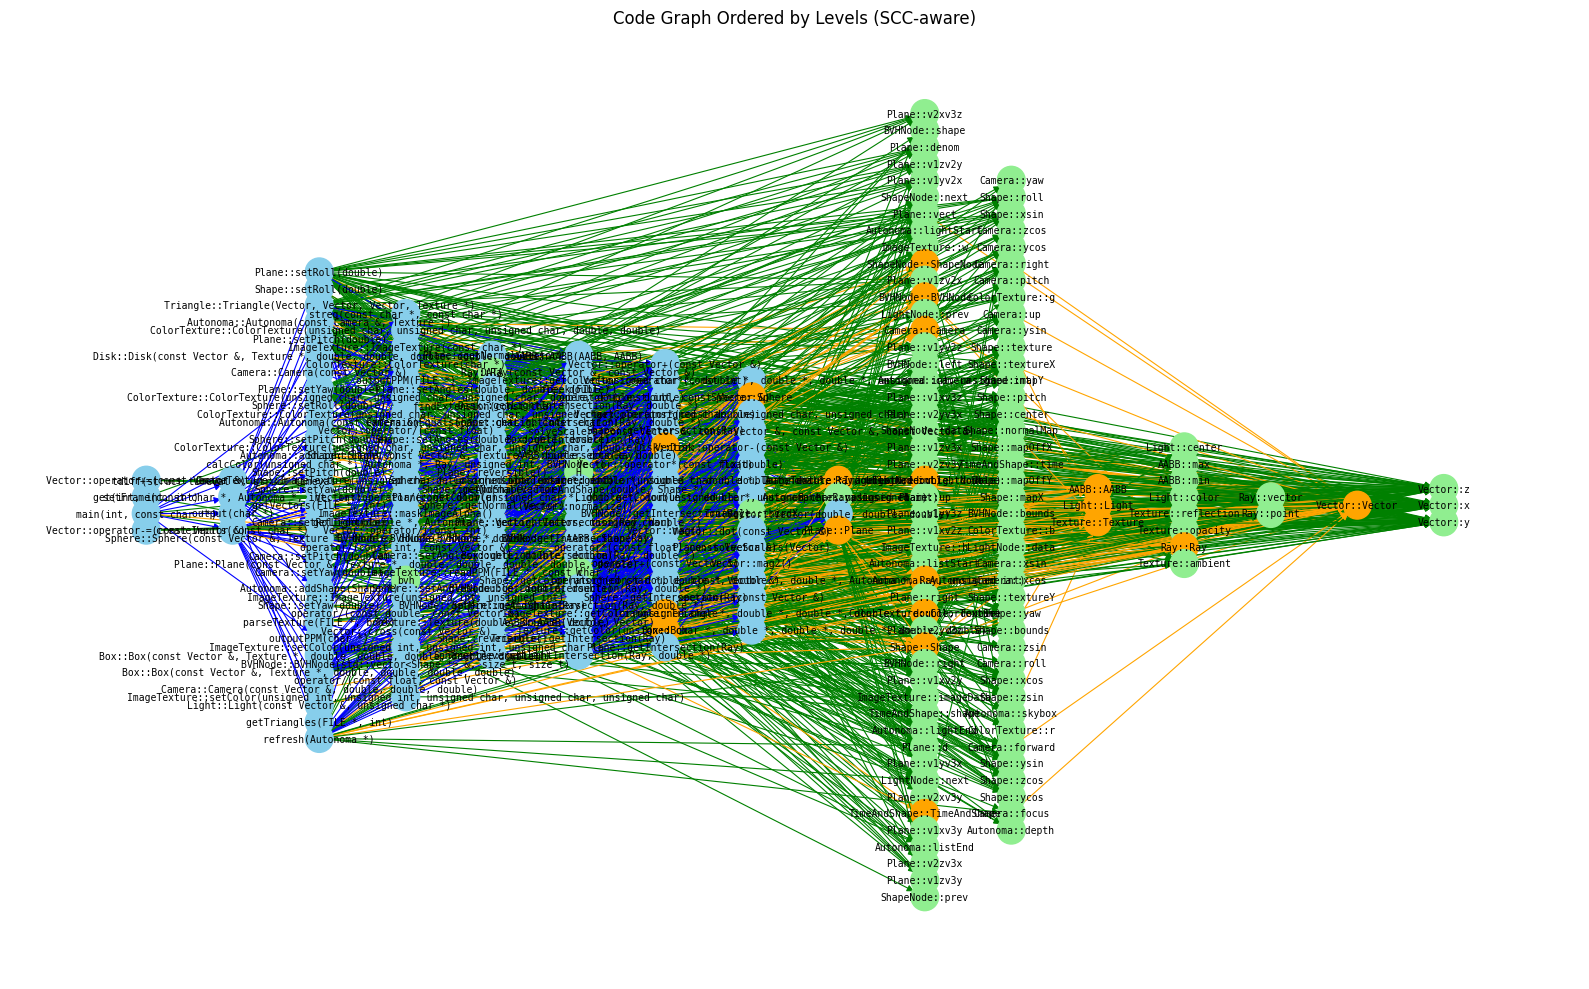

In [4]:
analyzer.plot(horizontal=True, node_filter=lambda node, attrs: (len(list(analyzer.predecessors(node))) != 0 or node == 'main(int, const char **)') 
              and is_kind(attrs["kind"], NodeKind.IN_CODEBASE))
# neural training law

Function: Vector::dot, Signature: Vector::dot(const Vector &), Calls: 1629005763, Chain: ['main.exe', '_start', 'main', 'setFrame', 'refresh', 'calcColor', 'BVHNode::getMinTimeAndShape', 'Plane::getIntersection', 'Vector::dot']
Function: BVHNode::getMinTimeAndShape, Signature: BVHNode::getMinTimeAndShape(Ray), Calls: 1533427828, Chain: ['main.exe', '_start', 'main', 'setFrame', 'refresh', 'calcColor', 'BVHNode::getMinTimeAndShape']
Function: Vector::Vector, Signature: Vector::Vector(double, double, double), Calls: 1323788368, Chain: ['main.exe', '_start', 'main', 'setFrame', 'refresh', 'calcColor', 'getLight', 'Box::getLightIntersection', 'Vector::operator+', 'Vector::Vector']
Function: AABB::intersects, Signature: AABB::intersects(Ray), Calls: 1160679654, Chain: ['main.exe', '_start', 'main', 'setFrame', 'refresh', 'calcColor', 'BVHNode::getMinTimeAndShape', 'AABB::intersects']
Function: Box::getLightIntersection, Signature: Box::getLightIntersection(Ray, double *), Calls: 857722366, 

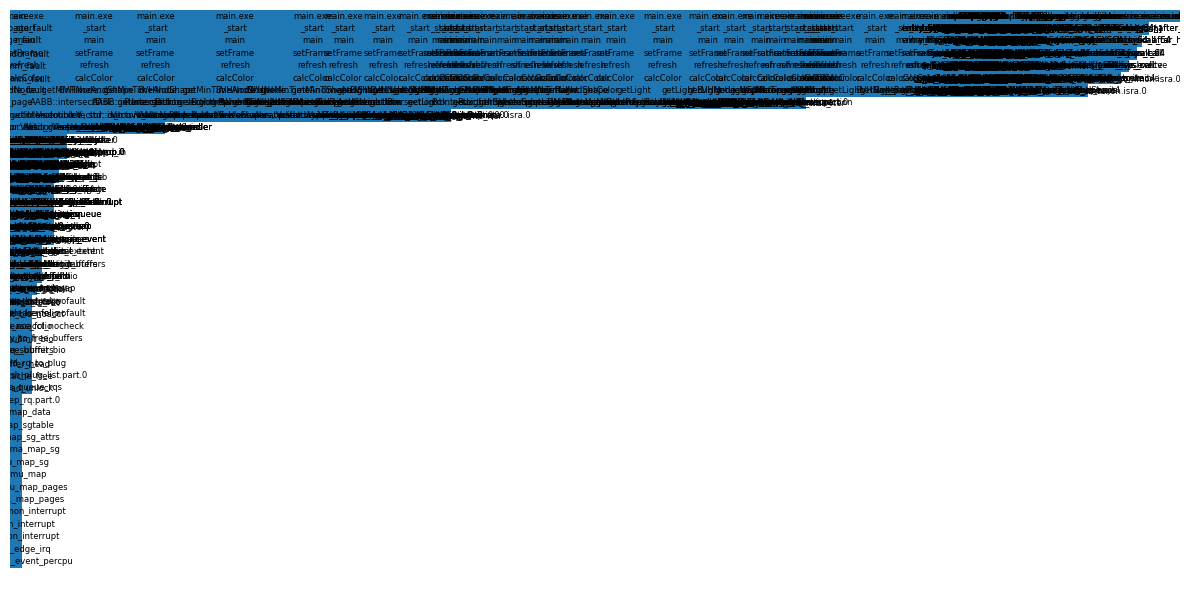

In [9]:
from analyzers.stack_analyzer import StackAnalyzer, FunctionStats

stack_analyzer = StackAnalyzer(f'{PROJECT_DIR}/perfstacks')
stats = stack_analyzer.get_top_functions(7)
for stat in stats:
    corresponding_signatures = analyzer.symbol_to_signatures.get(stat.name, [])
    if len(corresponding_signatures) == 1:
        print(f"Function: {stat.name}, Signature: {corresponding_signatures[0]}, Calls: {stat.exclusive_time}, Chain: {stat.call_chain}")
    elif len(corresponding_signatures) > 1:
        print(f"Warning - multiple signatures found for function: {stat.name}")
        print(f"Function: {stat.name}, Signatures: {', '.join(corresponding_signatures)}, Calls: {stat.exclusive_time}")

stack_analyzer.plot()

## Obfuscation

In [10]:
from obfuscators.code_obfuscator import CodeObfuscator
import random
import textwrap
from utils.string_utils import remove_comments

function_nodes = [node for node, attrs in analyzer.nodes(data=True) if is_kind(attrs["kind"], NodeKind.FUNCTION) and is_kind(attrs["kind"], NodeKind.IN_CODEBASE)]
random_node = random.choice(list(function_nodes))
successors = list(analyzer.successors(random_node))
nodes = [analyzer.nodes[n] for n in successors]
nodes.append(analyzer.nodes[random_node])

obfuscator = CodeObfuscator(tier=3, nodes=nodes, project_root=PROJECT_DIR)

code = "\n".join(n["code"] for n in nodes)

obfuscated_code = obfuscator.obfuscate(code)
deobfuscated_code = obfuscator.deobfuscate(obfuscated_code)

print("\nOriginal code:")
print(textwrap.indent(code, "  "))

print("\nObfuscated code:")
print(textwrap.indent(obfuscated_code, "  "))

print("\nObfuscation map:")
for orig, obf in obfuscator.obfuscation_map.items():
    print(f"  {orig} -> {obf}")

if remove_comments(deobfuscated_code) == remove_comments(code):
    print("\n✅ Deobfuscation successful!")
else:
    print("\n❌ Deobfuscation failed.")
    # print the deobfuscated code
    print(textwrap.indent(deobfuscated_code, "  "))
    


Original code:
  __MATHCALL_VEC (sin,, (_Mdouble_ __x));
  inline _GLIBCXX_CONSTEXPR long double
    sin(long double __x)
    { return __builtin_sinl(__x); }

  template<typename _Tp>
      inline _GLIBCXX_CONSTEXPR
      typename __gnu_cxx::__enable_if<__is_integer<_Tp>::__value, 
                                      double>::__type
      sin(_Tp __x)
      { return __builtin_sin(__x); }

  inline _GLIBCXX_CONSTEXPR float
    sin(float __x)
    { return __builtin_sinf(__x); }

  double sinfn(double x, double from, double to) {
     return (to - from) * sin(x * 6.28) + from;
  }


Obfuscated code:
  __MATHCALL_VEC (o_oncos,, (_Mdouble_ __x));
  inline _GLIBCXX_CONSTEXPR long double
    o_oncos(long double __x)
    { return __builtin_sinl(__x); }

  template<typename _Tp>
      inline _GLIBCXX_CONSTEXPR
      typename __gnu_cxx::__enable_if<__is_integer<_Tp>::__value, 
                                      double>::__type
      o_oncos(_Tp __x)
      { return __builtin_sin(__x); }

  

## Optimization

In [5]:
from optimizers.repo_optimizer import RepoOptimizer

optimizer = RepoOptimizer('gemini-1.5-flash', 'google', analyzer)
optimizer.optimize_repo()

/home/ayuram/pesquared/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package words to /home/ayuram/nltk_data...
[nltk_data]   Package words is already up-to-date!


Optimizing Vector::dot
--- RAW RESPONSE ---
{"insights": "The original `Vector::dot` function is already quite efficient.  Further optimization depends on the compiler and target architecture. We can explore compiler intrinsics or SIMD instructions for potential gains. However, the performance impact might be marginal unless `Vector::dot` is called extremely frequently in a performance-critical inner loop.", "optimizations": [{"brief_description": "Explore compiler intrinsics or SIMD instructions for potential performance gains.  This change is architecture dependent and may not provide a significant benefit unless `Vector::dot` is a performance bottleneck.", "function_name": "Vector::dot(const Vector&)", "new_imports": "// NO CHANGES NEEDED", "new_objects": "// NO CHANGES NEEDED", "rewritten_function": "double Vector::dot(const Vector& a) const {\n  return x * a.x + y * a.y + z * a.z;\n}\n// Consider compiler intrinsics or SIMD (e.g., using SSE, AVX) for potential further optimization

## $\text{Optimization}^2$

In [12]:
from utils.string_utils import markdown_to_dict, extract_markdown_blocks

def parse_diff(diff_text):
    """Parse a unified diff string into a list of hunks."""
    hunks = []
    current_hunk = []
    for line in diff_text.splitlines():
        if line.startswith('@@'):
            if current_hunk:
                hunks.append(current_hunk)
            current_hunk = [line]
        else:
            current_hunk.append(line)
    if current_hunk:
        hunks.append(current_hunk)
    return hunks

def parse_hunk_simple(hunk_lines):
    """Parse a hunk into leading context, trailing context, remove count, and add lines."""
    leading_context = []
    trailing_context = []
    remove_count = 0
    add_lines = []
    in_change = False
    for line in hunk_lines:
        if line.startswith(' '):
            if not in_change:
                leading_context.append(line[1:])
            else:
                trailing_context.append(line[1:])
        elif line.startswith('-'):
            in_change = True
            remove_count += 1
        elif line.startswith('+'):
            in_change = True
            add_lines.append(line[1:])
    return leading_context, trailing_context, remove_count, add_lines

def apply_hunk_fuzzy_simple(hunk_lines, corpus):
    """Apply a single hunk to the corpus fuzzily using context matching."""
    leading_context, trailing_context, remove_count, add_lines = parse_hunk_simple(hunk_lines)
    C_lead = len(leading_context)
    C_trail = len(trailing_context)
    
    # Skip if no context is provided to anchor the changes
    if C_lead == 0 and C_trail == 0:
        return
    
    # Search for the best position to apply the hunk
    best_score = -1
    best_i = -1
    max_pos = len(corpus) - C_lead - remove_count - C_trail + 1
    for i in range(max_pos if max_pos > 0 else 0):
        # Calculate similarity score for leading context
        score_lead = sum(1 for a, b in zip(corpus[i:i + C_lead], leading_context) if a == b)
        # Calculate similarity score for trailing context
        score_trail = sum(1 for a, b in zip(
            corpus[i + C_lead + remove_count:i + C_lead + remove_count + C_trail],
            trailing_context
        ) if a == b)
        score = score_lead + score_trail
        if score > best_score:
            best_score = score
            best_i = i
    
    # Apply the changes if a suitable position is found
    if best_i != -1:
        start_remove = best_i + C_lead
        end_remove = start_remove + remove_count
        del corpus[start_remove:end_remove]
        corpus[start_remove:start_remove] = add_lines

def apply_diff_fuzzy(corpus, diff_text):
    """
    Apply a diff with potentially inaccurate hunks to a corpus fuzzily.
    
    Args:
        corpus (list of str): The original text as a list of lines.
        diff_text (str): The diff in unified diff format.
    
    Returns:
        list of str: The modified corpus after applying the diff.
    """
    hunks = parse_diff(diff_text)
    for hunk in hunks:
        apply_hunk_fuzzy_simple(hunk, corpus)
    return corpus

# Example usage:

    # Sample corpus
file = analyzer.nodes[random_node]['file']
with open(file, 'r') as f:
    corpus = f.readlines()
corpus = analyzer.nodes[random_node]['code'].splitlines()
# Sample diff with one hunk
diff_text = extract_markdown_blocks(resp_dict['function'])[0]
# Apply the diff
modified_corpus = apply_diff_fuzzy(corpus, diff_text)
print("\n".join(modified_corpus))

NameError: name 'resp_dict' is not defined